# Employee Segmentation Analysis

Imports

In [454]:
import pandas as pd
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

Read Dataset

In [455]:
path = 'data/'
df = pd.read_csv(filepath_or_buffer=path+'cleaned_data.csv')
df#.sample(5)

,EmployeeID,BenefitID,SatisfactionScore,Comments,UsageFrequency,LastUsedDate,BenefitType,BenefitSubType,BenefitCost,Gender_Female,Gender_Male,Gender_Non-Binary,Department_Finance,Department_HR,Department_IT,Department_Marketing,Department_Sales,Age_Gen_Boomer,Age_Gen_Gen_X,Age_Gen_Gen_Z,Age_Gen_Millenial,TenureGroups_ >25_years,TenureGroups_16-25_years,TenureGroups_5-15_years,TenureGroups_<5_years,BenefitFlag_Cell_Phone_Allowance_Monthly_Communications,BenefitFlag_Childcare_After-School_Care,BenefitFlag_Childcare_On-Site_Infant_Care,BenefitFlag_Commuter_Benefits_Transit_Subsidy,BenefitFlag_Flexible_Spending_Account_Healthcare_FSA,BenefitFlag_Gym_Membership_Family_Membership,BenefitFlag_Gym_Membership_Tier_1_Partners,BenefitFlag_Gym_Membership_Tier_2_Partners,BenefitFlag_Gym_Membership_Tier_3_Partners,BenefitFlag_Health_Insurance_HDHP_Individual,BenefitFlag_Health_Insurance_HMO_Family,BenefitFlag_Health_Insurance_PPO_Family,BenefitFlag_Health_Insurance_PPO_Individual,BenefitFlag_Life_Insurance_Basic_Coverage,BenefitFlag_Life_Insurance_Dependent_Coverage,BenefitFlag_Life_Insurance_Supplemental_High_Amount,BenefitFlag_Life_Insurance_Supplemental_Standard,BenefitFlag_Professional_Development_Conference_Attendance,BenefitFlag_Retirement_Plan_401k_Basic_Matching,BenefitFlag_Retirement_Plan_401k_Catch-Up_Contributions,BenefitFlag_Retirement_Plan_401k_High_Contribution,BenefitFlag_Retirement_Plan_401k_Investment_Fees,BenefitFlag_Retirement_Plan_401k_Maximum_Matching,BenefitFlag_Retirement_Plan_401k_Standard_Matching,BenefitFlag_Technology_Stipend_Monthly_Internet_Allowance,BenefitFlag_Tuition_Reimbursement_Graduate_Degree,BenefitFlag_Tuition_Reimbursement_Individual_Courses,BenefitFlag_Tuition_Reimbursement_Professional_Certification,BenefitFlag_Tuition_Reimbursement_Undergraduate_Degree,BenefitFlag_Wellness_Programs_Premium_Discount_Tier_1
0,2540,3,4,Sufficient time off provided.,3,2023-10-20,Commuter Benefits,Transit Subsidy,325.00,False,False,True,False,True,False,False,False,False,False,True,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,3495,25,2,Coverage is minimal.,6,2023-10-06,Life Insurance,Supplemental Standard,774.91,False,True,False,False,False,True,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
2,403,18,4,Good plan with decent returns.,0,2023-11-20,Retirement Plan,401k Investment Fees,743.01,False,True,False,False,False,False,True,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
3,403,18,4,Good plan with decent returns.,5,2023-12-14,Retirement Plan,401k Investment Fees,743.01,False,True,False,False,False,False,True,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
4,1982,28,1,Disappointing service.,5,2024-07-02,Life Insurance,Dependent Coverage,165.54,False,True,False,False,False,False,True,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9607,1122,25,2,Coverage is minimal.,3,2023-10-02,Life Insurance,Supplemental Standar

Create usage vectors

In [456]:
df['LastUsedDate'] = pd.to_datetime(df['LastUsedDate'])
df['YearMonth'] = df['LastUsedDate'].dt.to_period('M')

In [457]:
cols = ['EmployeeID', 'UsageFrequency', 'YearMonth']
temp_profiles = df[cols].groupby(by=['EmployeeID', 'YearMonth'])['UsageFrequency'].sum().unstack(fill_value=0)
#temp_profiles['MeanUsage'] = temp_profiles.mean(axis=1)
#temp_profiles['MaxUsage'] = temp_profiles.max(axis=1)
temp_profiles

YearMonth,2023-08,2023-09,2023-10,2023-11,2023-12,2024-01,2024-02,2024-03,2024-04,2024-05,2024-06,2024-07,2024-08
EmployeeID,,,,,,,,,,,,,
2,0,0,0,0,0,0,0,0,0,5,0,0,0
3,0,7,0,0,0,4,0,0,0,0,0,0,0
4,0,0,0,0,2,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,3,0,0,0,0,0
6,0,0,0,0,2,0,0,3,0,0,5,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4996,0,0,2,0,0,0,0,0,0,1,0,0,0
4997,0,0,0,0,0,6,0,0,0,0,0,0,0
4998,0,0,0,0,3,3,0,0,0,0,0,0,0


Generate temporal profiles

In [458]:
needed_cols = list(df.columns)
cols_to_del = ['Comments', 'LastUsedDate', 'BenefitType', 'BenefitSubType', 'YearMonth']
for col in list(df.columns):
    if (col in cols_to_del) or ('BenefitFlag_' in col):
        if col in needed_cols:
            needed_cols.remove(col)
df_analysis = df[needed_cols]


#temp_profiles = df.groupby(by=['EmployeeID', 'BenefitID', 'YearMonth'])['UsageFrequency'].sum().unstack(fill_value=0)
#temp_profiles = df.groupby(by=['EmployeeID', 'BenefitID', 'YearMonth'])['UsageFrequency'].sum().unstack(fill_value=0)

In [459]:
df_analysis.select_dtypes(include='number')

,EmployeeID,BenefitID,SatisfactionScore,UsageFrequency,BenefitCost
0,2540,3,4,3,325.00
1,3495,25,2,6,774.91
2,403,18,4,0,743.01
3,403,18,4,5,743.01
4,1982,28,1,5,165.54
...,...,...,...,...,...
9607,1122,25,2,3,774.91
9608,4809,22,5,4,624.00
9609,4603,3,2,7,325.00
9610,4603,3,2,3,325.00


In [460]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
cols = list(df_analysis.select_dtypes(include='number').columns)
cols.remove('EmployeeID')
cols.remove('BenefitID')
df_analysis[cols] = std_scaler.fit_transform(df_analysis[cols])
df_analysis

/var/folders/q9/jcxc3j1d4nz012t1f9l_w0x80000gq/T/ipykernel_89134/2503545630.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_analysis[cols] = std_scaler.fit_transform(df_analysis[cols])


,EmployeeID,BenefitID,SatisfactionScore,UsageFrequency,BenefitCost,Gender_Female,Gender_Male,Gender_Non-Binary,Department_Finance,Department_HR,Department_IT,Department_Marketing,Department_Sales,Age_Gen_Boomer,Age_Gen_Gen_X,Age_Gen_Gen_Z,Age_Gen_Millenial,TenureGroups_ >25_years,TenureGroups_16-25_years,TenureGroups_5-15_years,TenureGroups_<5_years
0,2540,3,0.687814,-0.111463,-0.668533,False,False,True,False,True,False,False,False,False,False,True,False,False,False,False,True
1,3495,25,-0.724397,0.842857,0.862394,False,True,False,False,False,True,False,False,False,True,False,False,False,False,True,False
2,403,18,0.687814,-1.065783,0.753847,False,True,False,False,False,False,True,False,True,False,False,False,True,False,False,False
3,403,18,0.687814,0.524750,0.753847,False,True,False,False,False,False,True,False,True,False,False,False,True,False,False,False
4,1982,28,-1.430503,0.524750,-1.211135,False,True,False,False,False,False,True,False,False,False,False,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9607,1122,25,-0.724397,-0.111463,0.862394,False,True,False,True,False,False,False,False,False,True,False,False,False,True,False,False
9608,4809,22,1.393920,0.206644,0.348887,True,False,False,False,False,False,True,False,False,True,False,False,False,True,False,False
9609,4603,3,-0.724397,1.160964,-0.668533,True,False,False,False,False,True,False,False,False,False,False,True,False,False,True,False
9610,4603,3,-0.724397,-0.111463,-0.668533,True,False,False,False,False,True,False,False,False,False,False,True,False,False,True,False


In [461]:
df_analysis = df_analysis.groupby(by=["EmployeeID", "BenefitID"]).agg({
                                                                        'SatisfactionScore': 'sum',
                                                                        'UsageFrequency': 'sum',
                                                                        'BenefitCost': 'sum',
                                                                        'Gender_Female': 'max',
                                                                        'Gender_Male': 'max',
                                                                        'Gender_Non-Binary': 'max',
                                                                        'Department_Finance': 'max',
                                                                        'Department_HR': 'max',
                                                                        'Department_IT': 'max',
                                                                        'Department_Marketing': 'max',
                                                                        'Department_Sales': 'max',
                                                                        'Age_Gen_Boomer': 'max',
                                                                        'Age_Gen_Gen_X': 'max',
                                                                        'Age_Gen_Gen_Z': 'max',
                                                                        'Age_Gen_Millenial': 'max',
                                                                        'TenureGroups_ >25_years': 'max',
                                                                        'TenureGroups_16-25_years': 'max',
                                                                        'TenureGroups_5-15_years': 'max',
                                                                        'TenureGroups_<5_years': 'max'
                                                                    })
df_analysis

SatisfactionScore  UsageFrequency  BenefitCost  \
EmployeeID BenefitID                                                   
2          6                  -1.430503        0.524750     0.261912   
3          5                   1.393920       -0.429570    -1.519219   
           23                  0.687814        0.206644     1.523785   
           29                  1.393920        0.524750    -0.158122   
4          28                 -0.018292       -0.429570    -1.211135   
...                                 ...             ...          ...   
4998       29                 -0.036584       -0.222926    -0.316244   
4999       11                  0.687814        2.115284     1.385872   
           18                 -1.430503       -1.065783     0.753847   
5000       19                  1.393920        1.797177    -0.604800   
           22                  1.393920        0.842857     0.348887   

                      Gender_Female  Gender_Male  Gender_Non-Binary  \
EmployeeID BenefitID                                                  
2          6                   True        False              False   
3          5                   True        False              False   
           23                  True        False              False   
           29                  True        False              False   
4          28                 False         True              False   
...                             ...          ...                ...   
4998       29                  True        False              False   
4999       11                 False         True              False   
           18                 False         True              False   
5000       19                 False         True              False   
           22                 False         True              False   

                      Department_Finance  Department_HR  Department_IT  \
EmployeeID BenefitID                                                     
2          6                       False          False          False   
3          5                       False           True          False   
           23                      False           True          False   
           29                      False           True          False   
4          28                      False          False          False   
...                                  ...            ...            ...   
4998       29                      False          False           True   
4999       11                       True          False          False   
           18                       True          False          False   
5000       19                      False          False          False   
           22                      False          False          False   

                      Department_Marketing  Department_Sales  Age_Gen_Boomer  \
EmployeeID BenefitID                                                           
2          6                          True             False           False   
3          5                         False             False           False   
           23                        False             False           False   
           29                        False             False           False   
4          28                         True             False           False   
...                                    ...               ...             ...   
4998       29                        False             False            True   
4999       11                        False             False           False   
           18                        False             False           False   
5000       19                        False              True            True   
           22                        False              True            True   

                      Age_Gen_Gen_X  Age_Gen_Gen_Z  Age_Gen_Millenial  \
EmployeeID BenefitID                                                    
2          

Apply Clustering

In [545]:
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

def apply_PCA(df: pd.DataFrame, n_components: float) -> np.ndarray:
    pca = PCA(n_components=n_components, random_state=42, whiten=True)
    return pca.fit_transform(df)

def define_kmeans(n_clusters: int, n_init: int|str = 'auto') -> KMeans:
    # rs: 50, 45 good
    model = KMeans(init='k-means++',
                n_clusters=n_clusters,
                max_iter=50,
                random_state=100,
                algorithm='lloyd',
                n_init=n_init)
    
    return model

def get_optim_num_clusters(df: np.ndarray) -> int:
    sil_scores = []
    max_sil_score = 0
    best_num_clusters = 2
    for n_clusters in range(2, 10):
        
        model = define_kmeans(n_clusters=n_clusters, n_init=100)
    
        sil_score = silhouette_score(df, model.fit_predict(df))
        sil_scores.append(sil_score)
        if sil_score > max_sil_score:
            max_sil_score = sil_score
            best_num_clusters = n_clusters

    plt.figure(figsize=(10, 5))
    sns.lineplot(x=range(2, 10), y=sil_scores)
    sns.scatterplot(x=range(2, 10), y=sil_scores)
    plt.show()

    print(f"{best_num_clusters} is the optim numbers of clusters")

    return best_num_clusters

def apply_kmeans(df: pd.DataFrame, pca_components: int):

    # Apply PCA
    data = apply_PCA(df=df, n_components=pca_components)

    n_clusters = get_optim_num_clusters(df=data)

    model = define_kmeans(n_clusters=n_clusters)
    segments = model.fit_predict(data)
    centroids = model.cluster_centers_

    plt.figure(figsize=(7, 7))
    sns.scatterplot(x=data[:,0], y=data[:,3],  hue=segments)
    plt.scatter(centroids[:,0], centroids[:,3],marker = "x", s=150,linewidths = 5, zorder = 10, c='black')
    plt.show()

    return segments

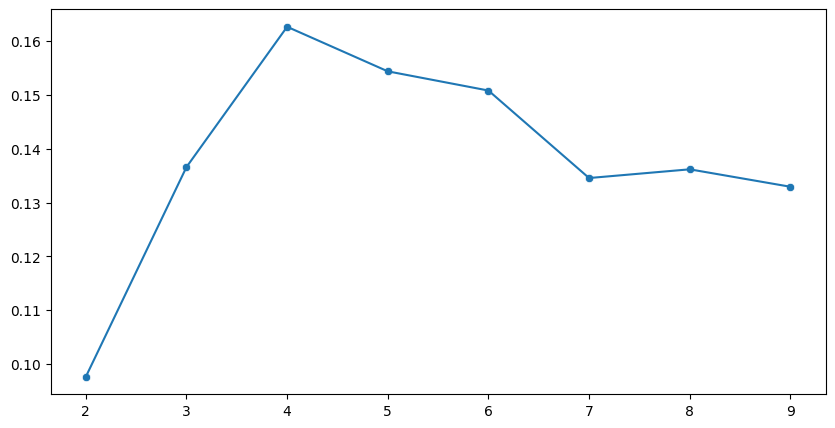

4 is the optim numbers of clusters


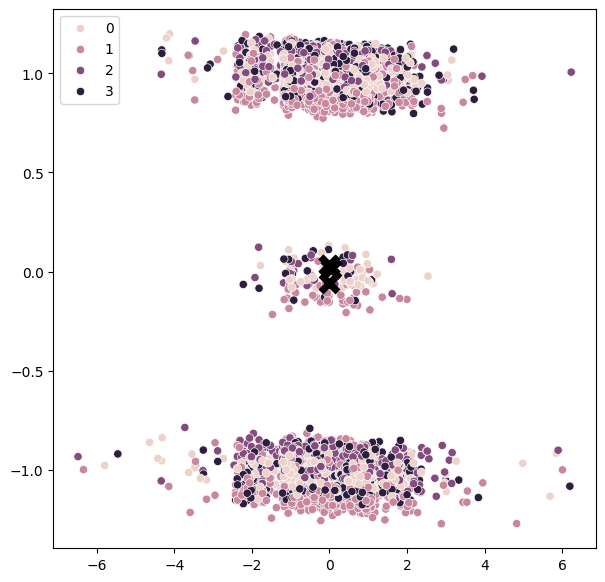

array([1, 3, 3, ..., 3, 1, 1], shape=(7626,), dtype=int32)

In [546]:
cols = ['EmployeeID', 'BenefitID', 'SatisfactionScore', 'UsageFrequency', 'BenefitCost', 'Gender_Male']
#df_analysis['Kmeans_seg'] = 
apply_kmeans(df=df_analysis, pca_components=0.95)

In [464]:
employee_kmeans_seg = df_analysis.reset_index(level=1, drop=True)['Kmeans_seg'].to_dict()

KeyError: 'Kmeans_seg'

In [ ]:
df['Kmeans_seg'] = df['EmployeeID'].map(employee_kmeans_seg)

Validate clusters

In [ ]:
# Validate slusters using Silhouette Analysis


Profile clusters by usage patterns and demographics

<Axes: xlabel='Kmeans_seg', ylabel='count'>

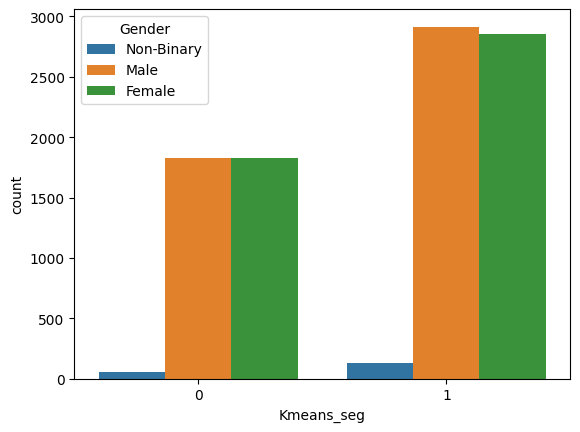

In [ ]:
df_analysis = df.copy()
gender_cols = [col for col in df.columns if 'Gender_' in col]
df_analysis['Gender'] = pd.from_dummies(df[gender_cols])
df_analysis['Gender'] = df_analysis['Gender'].str.replace('Gender_', '')

sns.countplot(df_analysis, x='Kmeans_seg', hue='Gender')

<Axes: xlabel='Kmeans_seg', ylabel='count'>

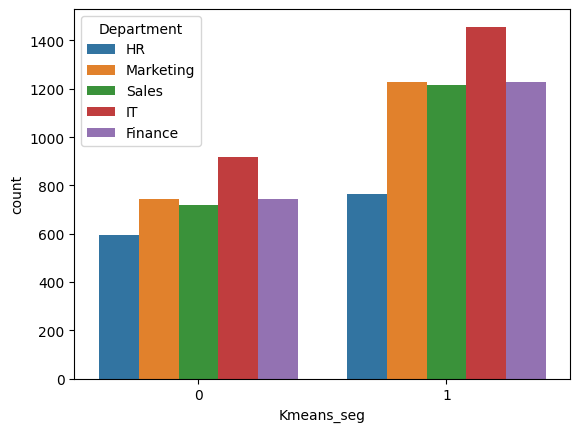

In [ ]:
gender_cols = [col for col in df.columns if 'Department_' in col]
df_analysis['Department'] = pd.from_dummies(df[gender_cols])
df_analysis['Department'] = df_analysis['Department'].str.replace('Department_', '')

sns.countplot(df_analysis, x='Kmeans_seg', hue='Department')

<Axes: xlabel='Kmeans_seg', ylabel='count'>

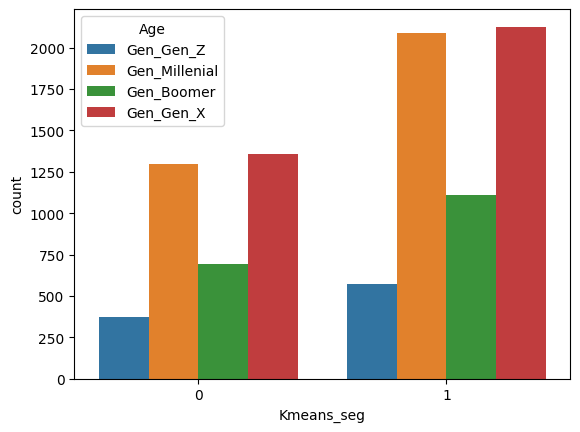

In [ ]:
gender_cols = [col for col in df.columns if 'Age_' in col]
df_analysis['Age'] = pd.from_dummies(df[gender_cols])
df_analysis['Age'] = df_analysis['Age'].str.replace('Age_', '')

sns.countplot(df_analysis, x='Kmeans_seg', hue='Age')

<Axes: xlabel='Kmeans_seg', ylabel='count'>

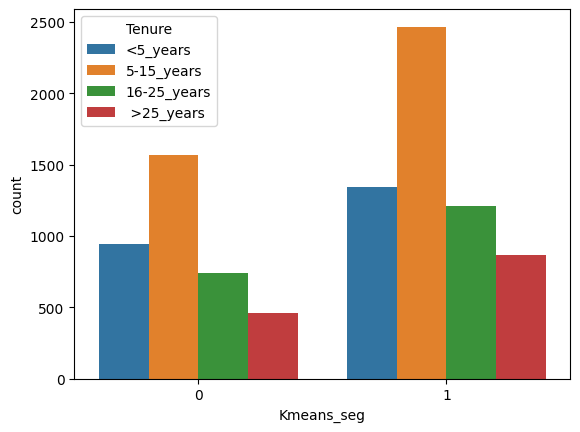

In [ ]:
gender_cols = [col for col in df.columns if 'TenureGroups_' in col]
df_analysis['Tenure'] = pd.from_dummies(df[gender_cols])
df_analysis['Tenure'] = df_analysis['Tenure'].str.replace('TenureGroups_', '')

sns.countplot(df_analysis, x='Kmeans_seg', hue='Tenure')

<Axes: xlabel='Kmeans_seg', ylabel='count'>

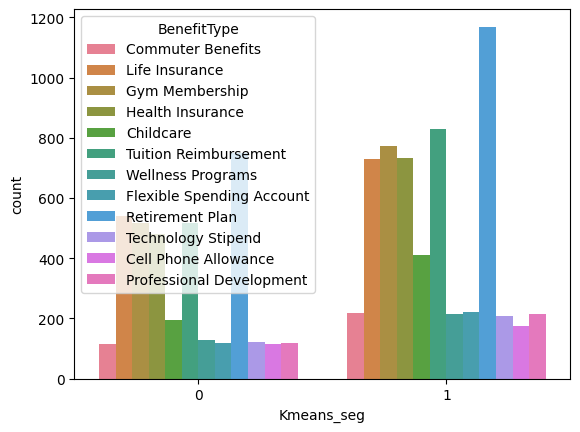

In [ ]:
sns.countplot(df_analysis, x='Kmeans_seg', hue='BenefitType')

<Axes: xlabel='Kmeans_seg', ylabel='count'>

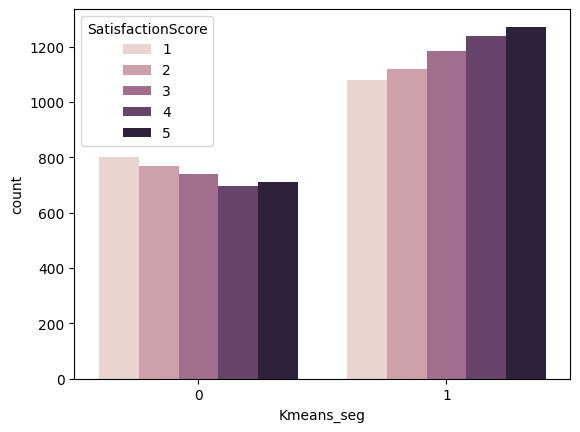

In [ ]:
sns.countplot(df_analysis, x='Kmeans_seg', hue='SatisfactionScore')

<Axes: xlabel='Kmeans_seg', ylabel='count'>

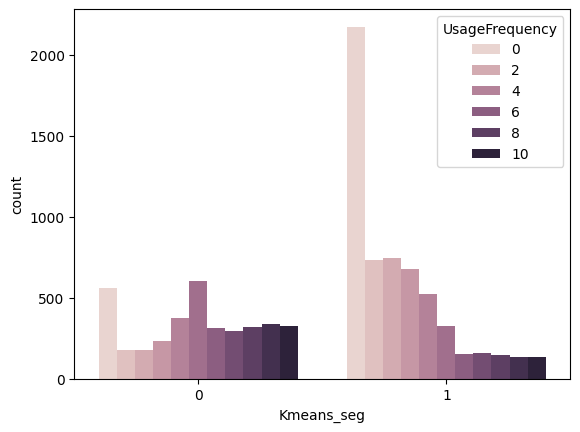

In [ ]:
sns.countplot(df_analysis, x='Kmeans_seg', hue='UsageFrequency')

<Axes: xlabel='Kmeans_seg', ylabel='count'>

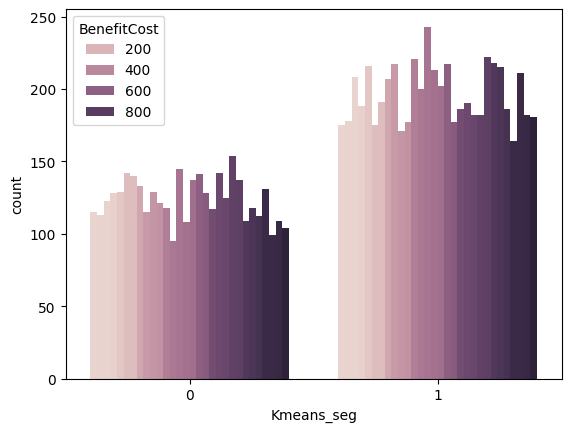

In [ ]:
sns.countplot(df_analysis, x='Kmeans_seg', hue='BenefitCost')